In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

# 1. Подберите параметры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.


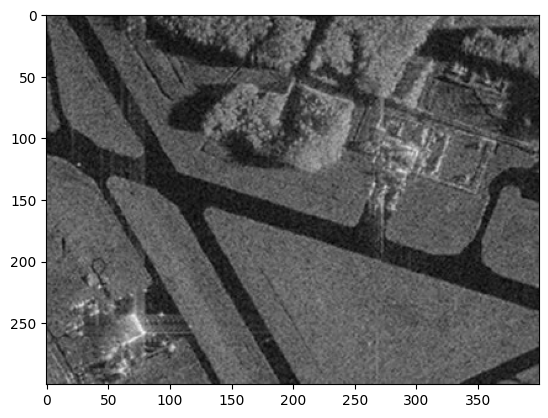

In [2]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
plt.imshow(image_gray, cmap="gray")

In [3]:
def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])
                                                            
    if abs(av_val - img[point]) <= T:
        return True
    
    return False

def region_growing(image, seed_point,homo_fun,r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r,image.shape[0] - r):
            for j in range(r,image.shape[1] - r):
                if mask[i,j]==0 and mask[i - r:i + r, j-r: j+r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        #print(count)
        mask += local_mask
        
    return mask*255

In [4]:
seed_point = (200,200)
mask = region_growing(image_gray,seed_point,homo_average,2,21)

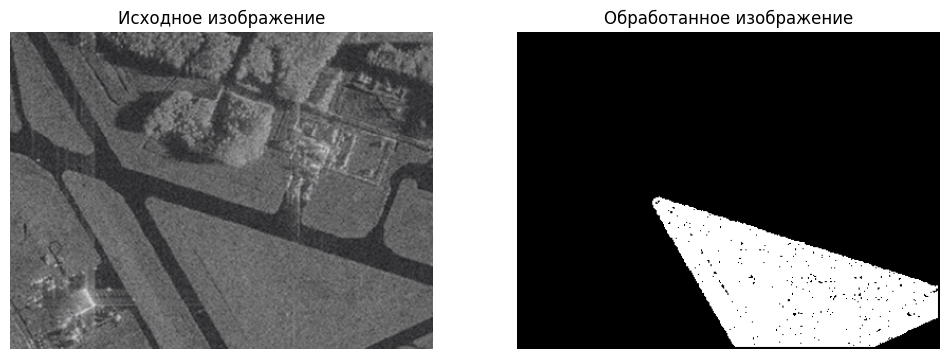

In [5]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1); plt.imshow(image, cmap='gray'); plt.title('Исходное изображение'); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(mask, cmap='gray'); plt.title('Обработанное изображение'); plt.axis('off')
plt.show()

# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.

In [6]:
def homo_median(image, mask, point, T):
    if np.count_nonzero(mask > 0) == 0:
        return False
    
    median_val = np.median(image[mask > 0])
    
    if abs(median_val - image[point]) <= T:
        return True
    
    return False

In [7]:
seed_point1 = (200,200)
mask1 = region_growing(image_gray,seed_point1,homo_median,2,21)

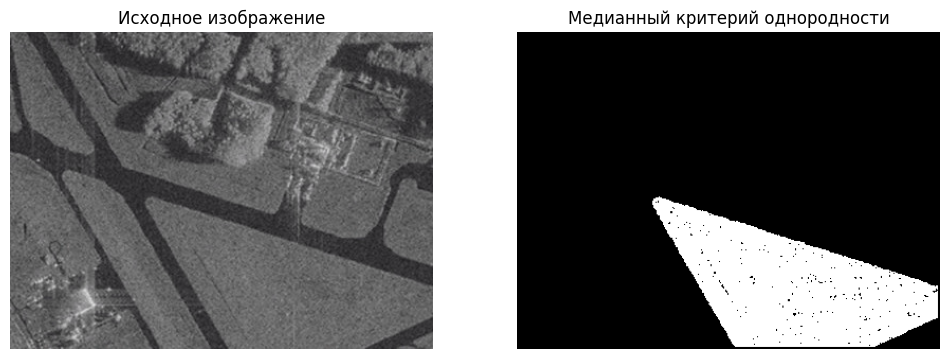

In [8]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1); plt.imshow(image, cmap='gray'); plt.title('Исходное изображение'); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(mask1, cmap='gray'); plt.title('Медианный критерий однородности'); plt.axis('off')
plt.show()

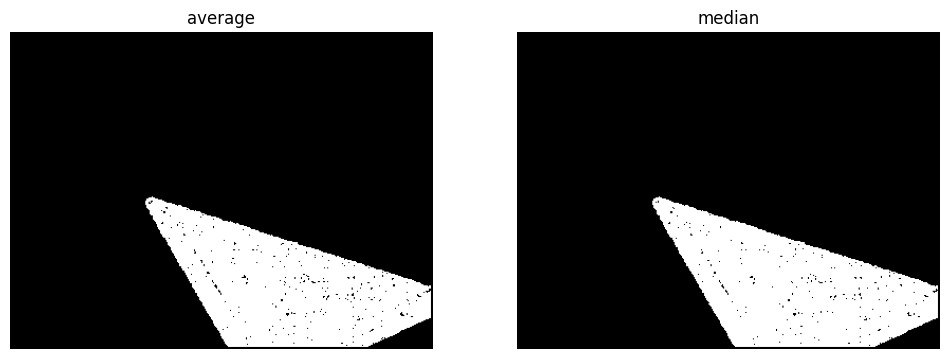

In [9]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1); plt.imshow(mask, cmap='gray'); plt.title('average'); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(mask1, cmap='gray'); plt.title('median'); plt.axis('off')
plt.show()

In [10]:
from skimage.metrics import structural_similarity, mean_squared_error

(ssim_average, diff_average) = structural_similarity(image_gray, mask, full=True)
(ssim_median, diff_median) = structural_similarity(image_gray, mask1, full=True)

mse_average = mean_squared_error(image_gray, mask)
mse_median = mean_squared_error(image_gray, mask1)

diff_average = (diff_average * 255).astype("uint8")
diff_median = (diff_median * 255).astype("uint8")

print("Результаты сравнения:")
print(f"average + img: SSIM = {ssim_average:.4f}; MSE = {mse_average:.4f}")
print(f"median + img: SSIM = {ssim_median:.4f}; MSE = {mse_median:.4f}")

Результаты сравнения:
average + img: SSIM = 0.0493; MSE = 10985.7323
median + img: SSIM = 0.0519; MSE = 11001.2172


# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

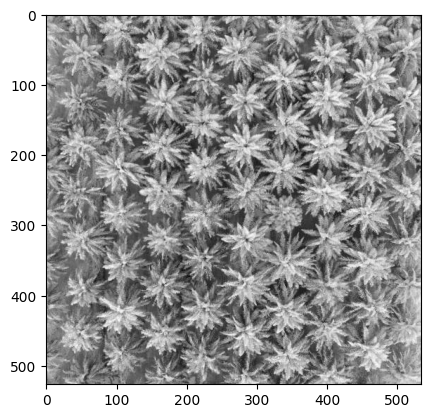

In [11]:
image1 = cv2.imread('palm_1.jpg')
image_gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY) 

blur = cv2.GaussianBlur(image_gray1, (5,5), 0)

plt.imshow(image_gray1, cmap="gray")

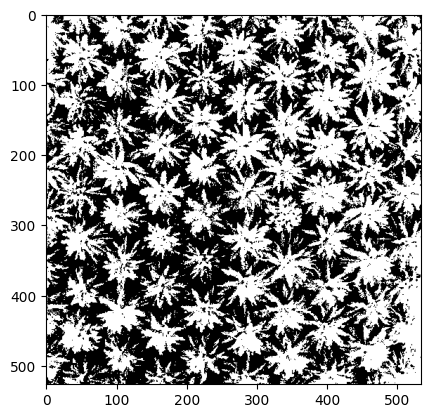

In [12]:
ret, thresh = cv2.threshold(image_gray1,0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(thresh, cmap="gray")

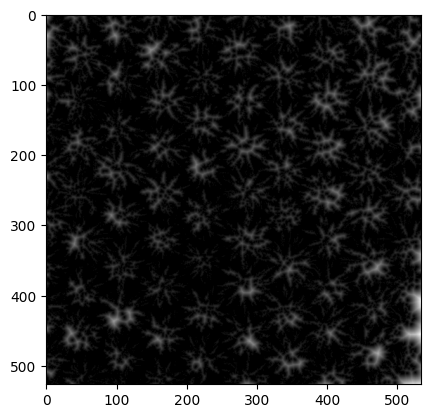

In [13]:
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5) 
plt.imshow(dist, cmap="gray")

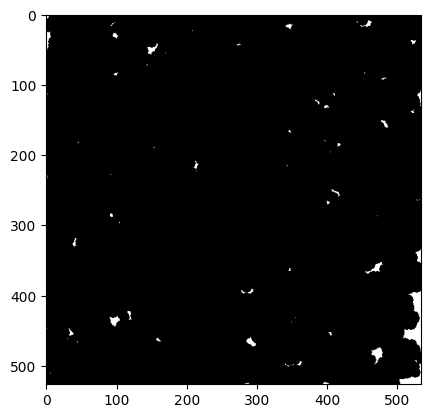

In [14]:
ret, sure_fg = cv2.threshold(dist, 0.37 * dist.max(), 255, cv2.THRESH_BINARY) 
plt.imshow(sure_fg, cmap="gray")

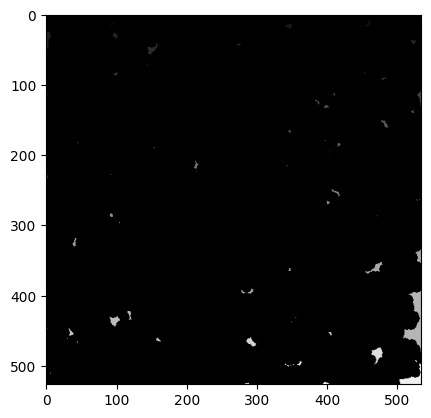

In [15]:
sure_fg = sure_fg.astype(np.uint8)
ret, markers = cv2.connectedComponents(sure_fg) 
plt.imshow(markers, cmap="gray")

Примерное количество пальм: 73


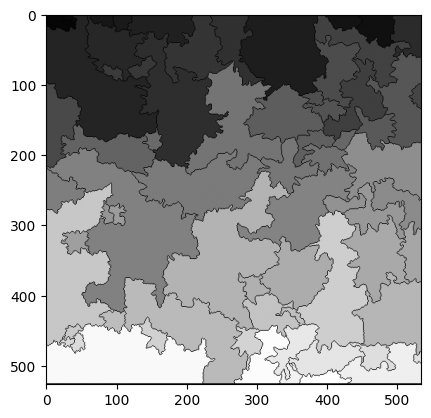

In [16]:
markers = cv2.watershed(image1, markers)
plt.imshow(markers, cmap="gray")
print('Примерное количество пальм:', len(np.unique(markers)))